示例数据树结构：/Users/curiostudio/Desktop/geometry
├── group_best
│   ├── activation
│   │   └── longtail_50
│   │       ├── EleutherAI
│   │       │   ├── pythia-410m-deduped
│   │       │   │   └── prob
│   │       │   │       ├── 500_10.debug
│   │       │   │       ├── 500_10.json
│   │       │   │       ├── 500_100.json
│   │       │   │       └── 500_50.json
│   │       │   └── pythia-70m-deduped
│   │       │       └── prob
│   │       │           ├── 500_10.debug
│   │       │           ├── 500_10.json
│   │       │           ├── 500_100.json
│   │       │           └── 500_50.json
│   │       └── prob
│   └── weight
...
├── group_target_size
│   ├── activation
│   │   └── longtail_50
...
└── individual


In [1]:
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ROOT_dir = Path('/Users/jliu/workspace/RAG')

In [14]:
-0.00010375499725341797 < -0.00015833616256713868

False

In [17]:
np.abs(0.00010375499725341797) < np.abs(-0.00015833616256713868) 

True

In [16]:
np.abs(-0.00015833616256713868) 

0.00015833616256713868

In [2]:

class JsonProcessor:
    """Class for handling JSON serialization with NumPy type conversion."""
    @staticmethod
    def load_json1(filepath: Path) -> dict:
        """Load a JSON file into a dictionary."""
        with open(filepath, encoding="utf-8") as f:
            return json.load(f)
        
    

    def load_json(filepath):
        with open(filepath, encoding="utf-8") as f:
            content = f.read()
        try:
            # Try to parse just the first valid JSON object
            decoder = json.JSONDecoder()
            obj, end = decoder.raw_decode(content)
            return obj  # obj is your dictionary
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            return None

# case style for the results
case_styles = {
    "boost":    {"marker":"o","linestyle":"-"},
    "suppress": {"marker":"s","linestyle":"--"},
    "random": {"marker":"^","linestyle":":"},
}

case_styles_group =  {"marker":"o","linestyle":"-"}
    
colors = {
    10: 'blue',
    50: 'green',
    100: 'red',
}


SETTING_MAP = {"group_best":"gbest","group_target_size":"gtsize","individual":"indiv"}
MODEL_MAP   = {"pythia-70m-deduped":"70m","pythia-410m-deduped":"410m"}


## Geometric analyses


In [3]:


def slugify(text):
    return re.sub(r'\W+','_', text).strip('_').lower()


# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")




In [4]:
class DataProcessor:
    """Process and analyze dimensional data from JSON files."""

    def __init__(
        self, 
        data_dir: Path,
        space_type: str, 
        model_name_lst: list[str], 
        sample_size_lst: list[int], 
        group_type_lst: list[str],
        case_styles: dict[str],
        colors: dict[str],
        setting_map: dict[str] = SETTING_MAP,
        model_map: dict[str] = MODEL_MAP
    ):
        """Initialize the DataProcessor with the data directory and processing parameters."""
        self.data_dir = data_dir
        self.space_type = space_type
        self.model_name_lst = model_name_lst
        self.sample_size_lst = sample_size_lst
        self.group_type_lst = group_type_lst
        self.filepath_lst, self.file_info = self.get_filepath_list()
        self.case_styles = case_styles
        self.colors = colors
        self.setting_map = setting_map
        self.model_map = model_map
    
    def get_filepath_list(self) -> tuple[list[Path], list[list[str]]]:
        """Generate lists of file paths based on initialized parameters."""
        filepath_lst = []
        file_info = []
        
        for group_type in self.group_type_lst:
            for model_name in self.model_name_lst:
                for sample_size in self.sample_size_lst:
                    filepath_lst.append(
                        self.data_dir / group_type / self.space_type / "longtail_50/EleutherAI" / 
                        model_name / "prob" / f"500_{sample_size}.json"
                    )
                    file_info.append([model_name, sample_size, group_type])
        
        return filepath_lst, file_info
    
    
    def load_single_dim(self, data_all: dict, step: str, file_info: list[str]) -> pd.DataFrame:
        """Extract stepwise stats from JSON data."""
        try:
            data = data_all[step]["dimensionality"]
            records = [{
                'model': file_info[0],
                'step': step,
                'sample_size': file_info[1],
                'group_type': file_info[2],
                'boost': data['boost'].get('dim_prop'),
                'suppress': data['suppress'].get('dim_prop'),
                'random': data['random_1'].get('dim_prop'),
            }]
            return pd.DataFrame.from_records(records)
        except Exception:
            print(f"Error processing file info: {file_info}")
            return None
    
    def load_single_between(self, data_all: dict, step: str, file_info: list[str]) -> pd.DataFrame:
        """Extract stepwise stats from JSON data."""
        
        data = data_all[step]["orthogonality"]["between"]
        records = [{
            'model': file_info[0],
            'step': step,
            'sample_size': file_info[1],
            'group_type': file_info[2],
            "boost_vs_random_1": data["boost_vs_random_1"].get('mean_cross_cosine_similarity'),
            "suppress_vs_random_1": data["suppress_vs_random_1"].get('mean_cross_cosine_similarity'),
            "boost_vs_suppress": data["boost_vs_suppress"].get('mean_cross_cosine_similarity'),
            "random_1_vs_random_2": data["random_1_vs_random_2"].get('mean_cross_cosine_similarity'),
        }]
        return pd.DataFrame.from_records(records)
    
    
    
    def load_data(self,stat:str) -> pd.DataFrame:
        """Run the full data loading and plotting pipeline."""
        # Load all file paths
        filepath_lst, file_info_lst = self.get_filepath_list()
        
        # Load all files
        df = pd.DataFrame()
        for file_idx, filepath in enumerate(filepath_lst):
            data_all = JsonProcessor.load_json(filepath)
            # Loop through different steps
            for step in data_all.keys():
                if stat == "dim":
                    df_row = self.load_single_dim(data_all, step, file_info_lst[file_idx])
                if stat == "across":
                    df_row = self.load_single_between(data_all, step, file_info_lst[file_idx])
                if df_row is not None:
                    df = pd.concat([df, df_row])
        # sort and convert dataformat
        df['step'] = df['step'].astype(int)
        return df.sort_values(['model','step'])
    
    def plot_dim(
        self,
        df: pd.DataFrame,
        metric_lst: list[str],
        out_dir: Path,
        show: bool = True,
        y_range = [0.85,1]
    ) -> None:
        """Plot multiple metrics together for a specific model and sample size."""
        # Create output directory if it doesn't exist
        out_dir.mkdir(parents=True, exist_ok=True)
        df_grouped = df.groupby(["model","group_type"])
        # loop over the model
        for plot_info, df_group in df_grouped:
                # loop over sample sizes
                data = df_group.groupby("sample_size")
                for sample_size, data_group in data:
                    for metric in metric_lst:
                        style = self.case_styles[metric]
                        plt.plot(
                            data_group["step"].to_list(),
                            data_group[metric].to_list(),
                            color=colors[sample_size],
                            marker=style["marker"],
                            linestyle=style["linestyle"],
                            label=f"{sample_size}_{metric}"
                        )
                        
                plt.ylim(y_range)
                plt.title(f"{self.model_map[plot_info[0]]} | {self.setting_map[plot_info[1]]} | dim_prop")
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.grid(alpha=0.3)
                if show:
                    plt.show()

        
    def plot_ortho(
        self,
        df: pd.DataFrame,
        metric_lst: list[str],
        out_dir: Path,
        show: bool = True,
        y_range = [0.85,1]
    ) -> None:
        """Plot multiple metrics together for a specific model and sample size."""
        # Create output directory if it doesn't exist
        out_dir.mkdir(parents=True, exist_ok=True)
        df_grouped = df.groupby(["model","group_type"])
        # loop over the model
        for plot_info, df_group in df_grouped:
                # loop over sample sizes
                data = df_group.groupby("sample_size")
                
                for metric in metric_lst:
                    for sample_size, data_group in data:
                        plt.plot(
                            data_group["step"].to_list(),
                            data_group[metric].to_list(),
                            color=colors[sample_size],
                            marker=self.case_styles["marker"],
                            linestyle=self.case_styles["linestyle"],
                            label=sample_size
                        )
                    plt.ylim(y_range)
                    plt.title(f"{self.model_map[plot_info[0]]} | {self.setting_map[plot_info[1]]} | {metric}")
                    plt.legend()
                    plt.grid(alpha=0.3)
                    if show:
                        plt.show()





In [ ]:
# loop over differento conditions
out_dir= ROOT_dir/'fig/geometry/weight'
metric_lst = ["boost","suppress","random"]
# intialize the class
data_processor = DataProcessor(
    data_dir = ROOT_dir/'results/geometry/',
    space_type = "weight",
    model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"], 
    sample_size_lst = [10,50,100],
    group_type_lst = ["individual","group_best","group_target_size"],
    case_styles =case_styles,
    colors=colors
)

# load the effective dimension
df = data_processor.load_data("dim")
data_processor.plot_dim(
        df=df,
        metric_lst = metric_lst,
        out_dir = out_dir,
        show = True
    )

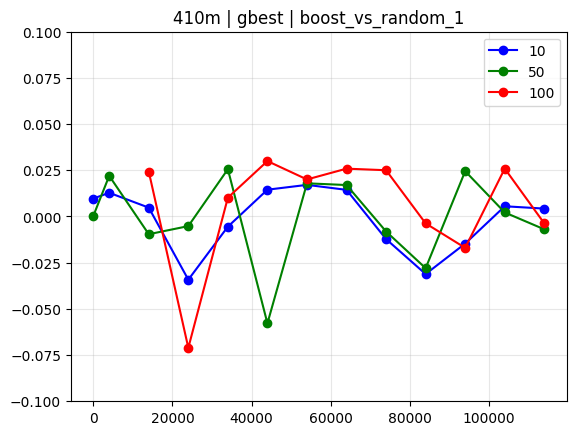

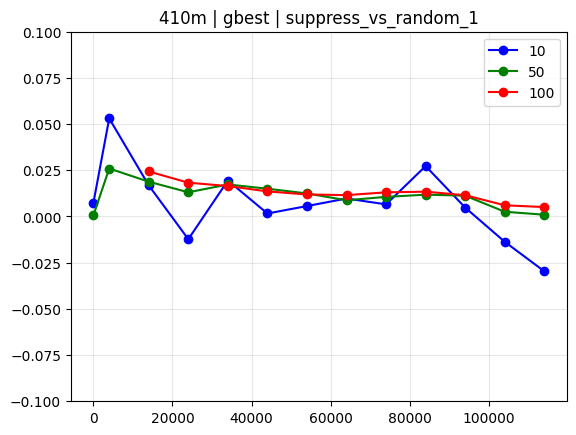

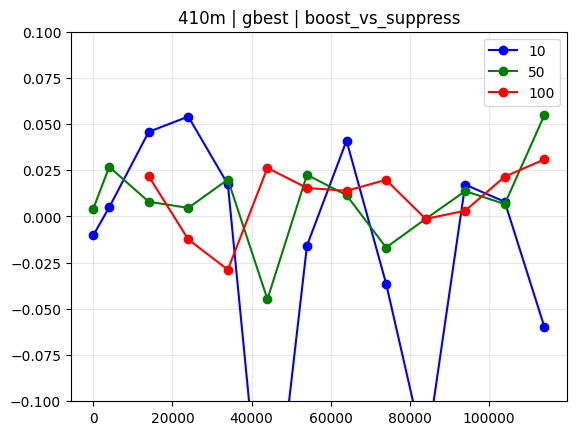

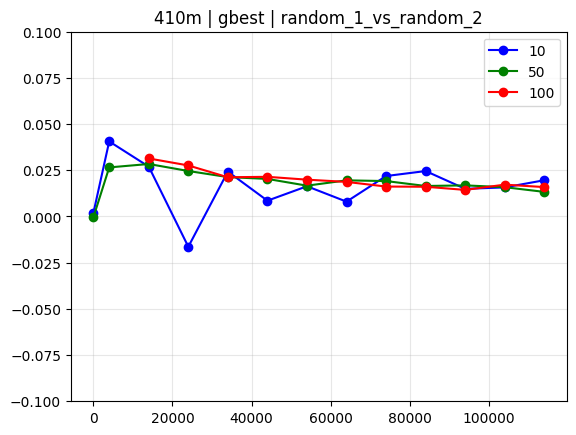

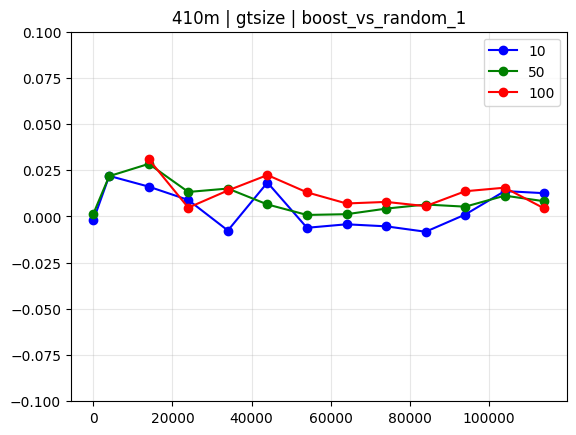

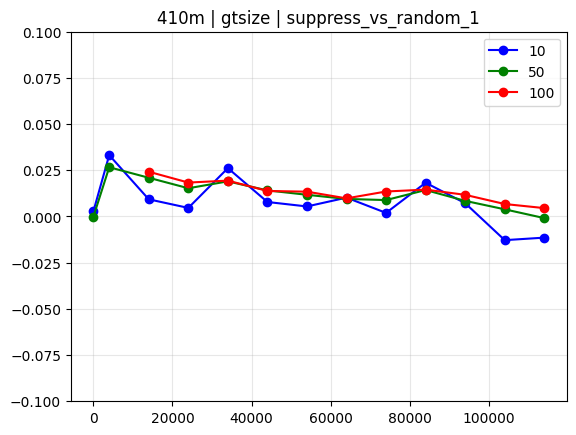

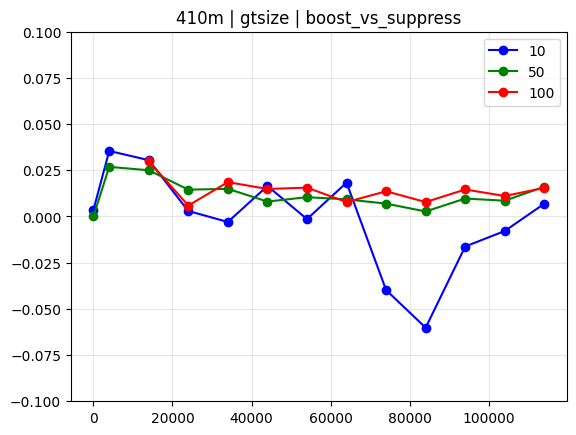

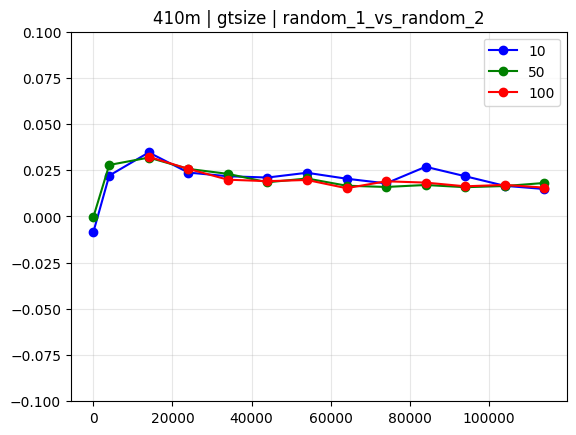

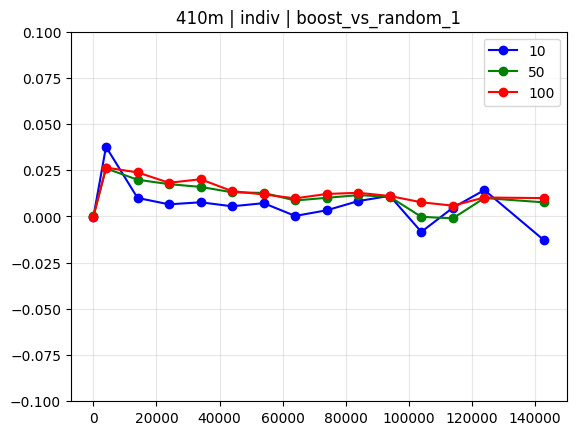

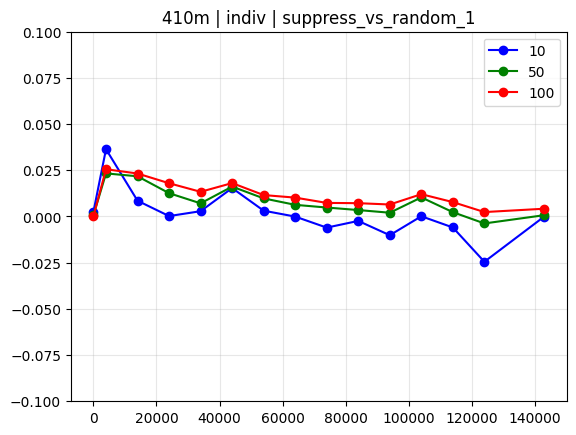

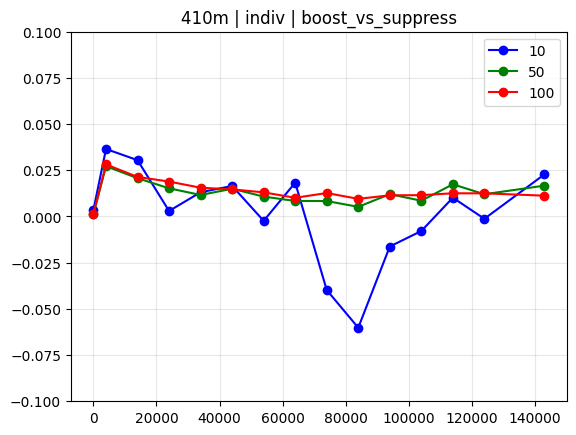

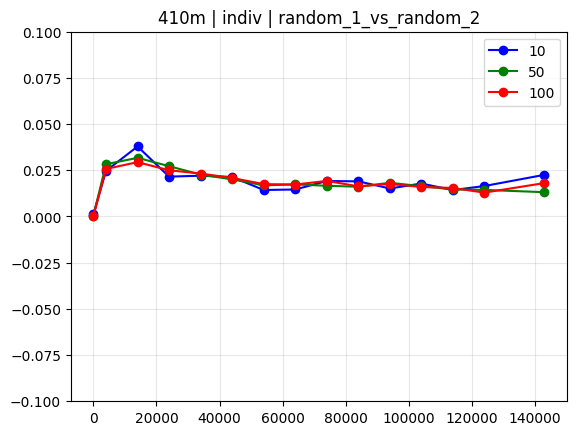

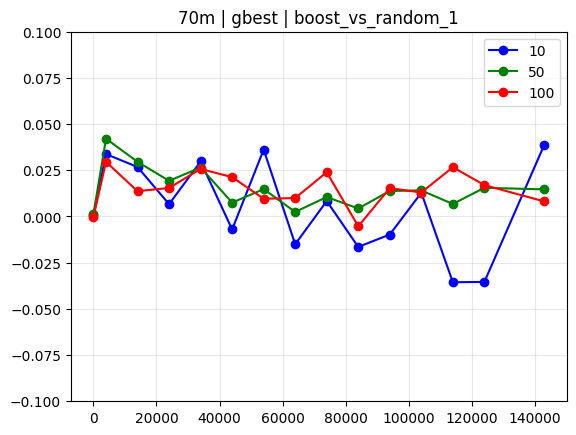

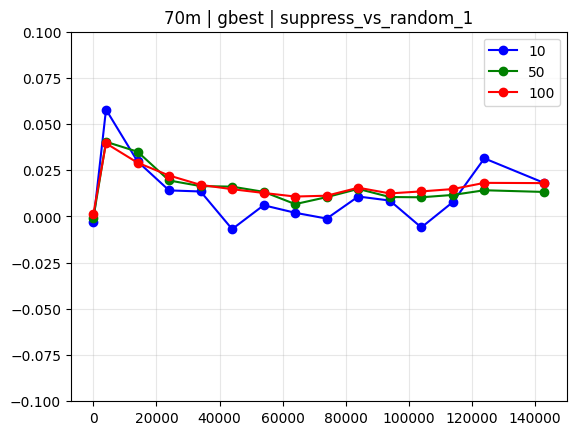

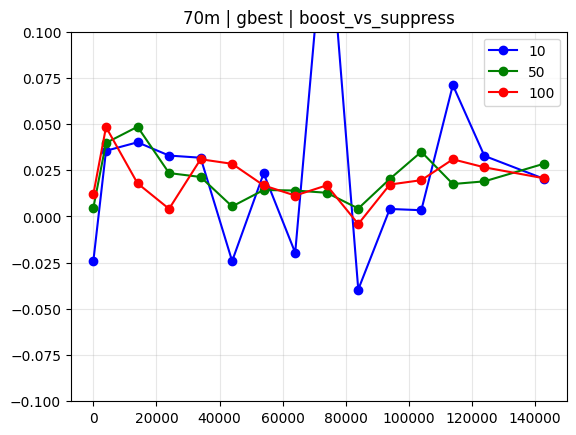

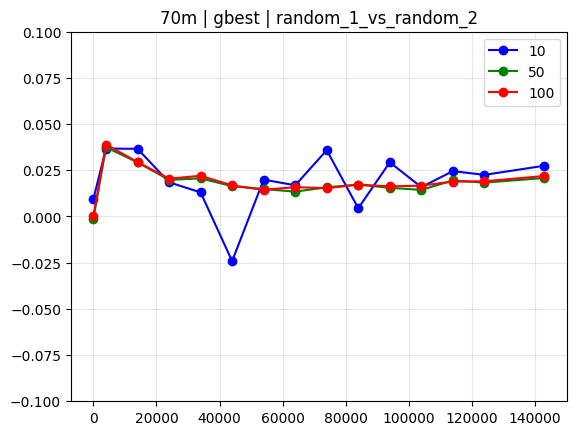

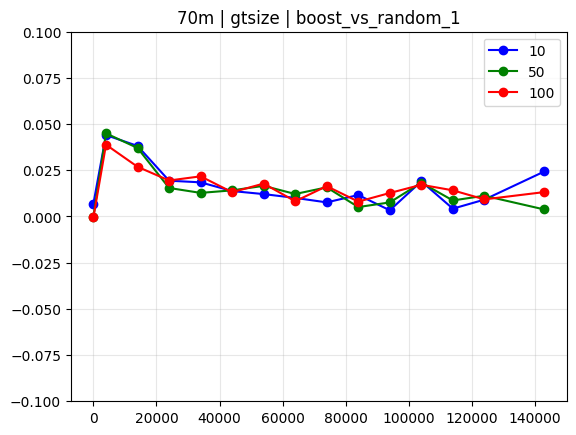

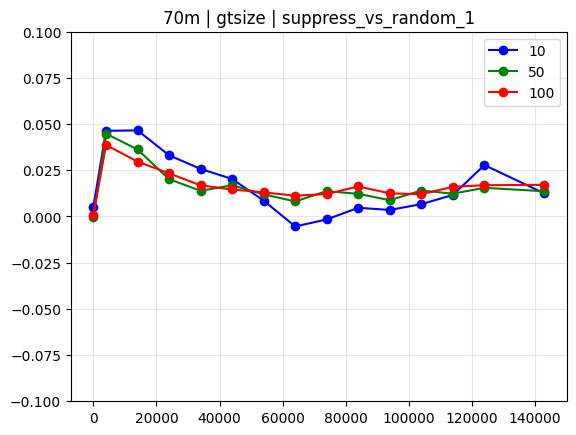

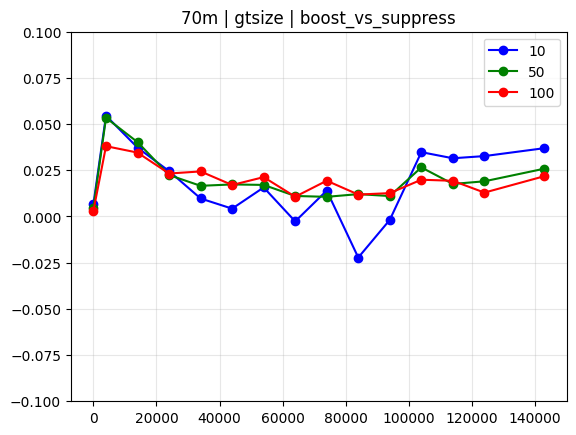

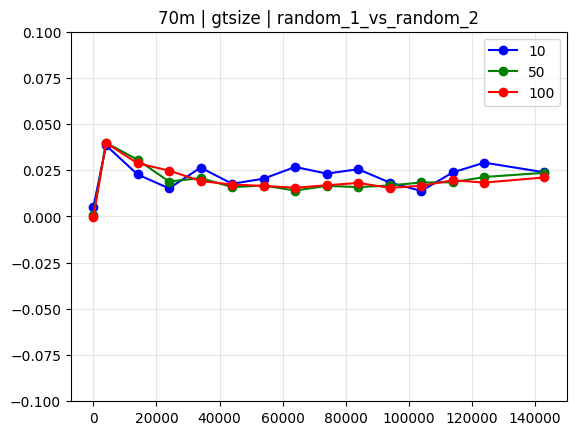

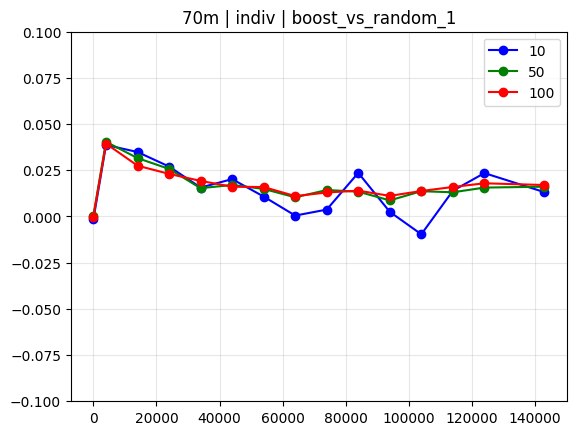

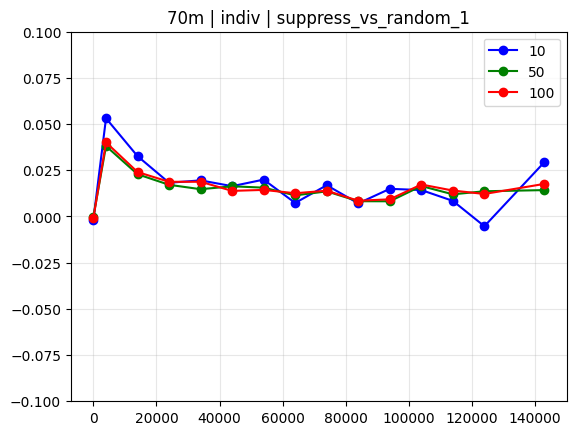

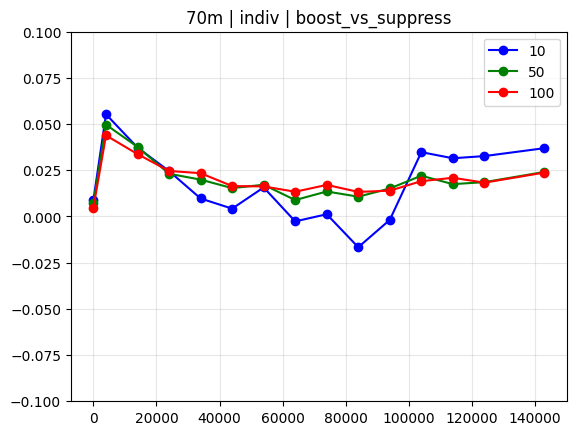

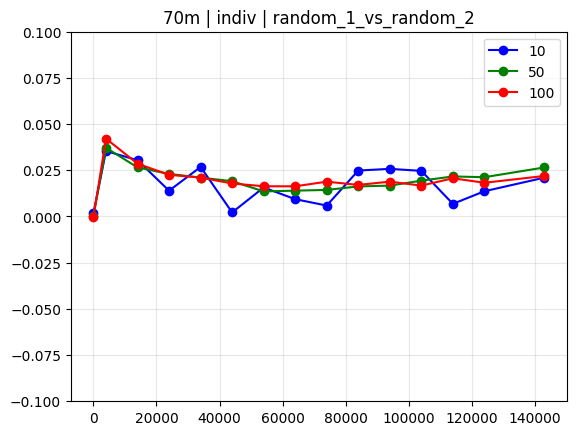

In [131]:
# loop over differento conditions
out_dir= ROOT_dir/'fig/geometry/weight'
# intialize the class
data_processor = DataProcessor(
    data_dir = ROOT_dir/'results/geometry/',
    space_type = "weight",
    model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"], 
    sample_size_lst = [10,50,100],
    group_type_lst = ["individual","group_best","group_target_size"],
    case_styles =case_styles_group,
    colors=colors
)

metric_lst = ['boost_vs_random_1','suppress_vs_random_1', 'boost_vs_suppress', 'random_1_vs_random_2']
df = data_processor.load_data("across")
data_processor.plot_ortho(
        df=df,
        metric_lst = metric_lst,
        out_dir = out_dir,
        show = True,
        y_range = [-0.1,0.1]
    )

## Reflection analyses

In [9]:
def get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)->list:
    """Iterate file names."""
    filepath_lst = []
    file_info = []
    for model_name in model_name_lst:
        for step in step_lst:
            for sample_size in sample_size_lst:
                for class_num in class_num_lst:
                    for group_type in group_type_lst: 
                        filepath_lst.append(DATA_DIR / model_name / "prob" / str(step) / "500" / str(sample_size) / str(class_num) / group_type / filename)
                        file_info.append([model_name,step,sample_size])
    return filepath_lst, file_info


def load_data(filepath, file_info):
    """Extract stat form json file."""
    try:
        data = json.loads(filepath.read_text(encoding='utf-8'))
        records = []
        records.append({
            'model': file_info[0],
            'step': file_info[1],
            'sample_size': file_info[2],
            'special': data["1"].get('delta_loss_diff'),
            'common': data["-1"].get('delta_loss_diff'),
        })
        return pd.DataFrame.from_records(records)
    except:
        print(filepath)
        return None
    

# plot the results
def plot_metrics_by_model(
    df: pd.DataFrame,
    metric: str,
    shot: int,
    out_dir: Path,
    show: bool = False
):
    """
    For each model in df, plot 'metric' vs categorical step index,
    with separate lines for each sample_size.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    for model, group in df.groupby('model'):
        # Unique sorted steps across this model
        steps = sorted(group['step'].unique())
        step_to_idx = {s: i for i, s in enumerate(steps)}

        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot each sample size
        for sample_size, color in zip(sorted(group['sample_size'].unique()), ['blue', 'green', 'red']):
            sub = group[group['sample_size'] == sample_size]
            # Map actual step values to category index
            x = [step_to_idx[val] for val in sub['step']]
            ax.plot(
                x,
                sub[metric],
                marker='o',
                color=color,
                label=f"{sample_size} samples"
            )

        # Align x-axis labels to categories
        ax.set_xticks(list(range(len(steps))))
        ax.set_xticklabels(steps, rotation=45)
        ax.set_xlabel('Step')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f"{model} | {shot}-Shot | {metric.replace('_',' ').title()}")
        ax.legend(title='Sample Size')
        ax.grid(alpha=0.3)

        # Save
        slug = slugify(model)
        fname = out_dir / f"{slug}_shot{shot}_{metric}.png"
        fig.tight_layout()
        fig.savefig(fname, dpi=200)
        if show:
            plt.show()
        else:
            plt.close(fig)
        print(f"Saved plot to {fname}")



def run_pipeline(DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename):
    """Run the plotting pipeline."""
    # load all file pathss
    filepath_lst, file_info_lst = get_filepath_list(DATA_DIR,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)
    # load all files
    df = pd.DataFrame()
    for file_idx, filepath in enumerate(filepath_lst):
        df_row = load_data(filepath, file_info_lst[file_idx])
        df = pd.concat([df,df_row])

    # plot out the results
    for metric in metric_lst:
        plot_metrics_by_model(
            df,
            metric=metric,
            shot = 2,
            out_dir= out_dir,
            show = True
        )




/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/24000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/34000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/44000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/54000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/64000/500/50/2/individual/ref_svm_linear_extreme.json
/Users/jliu/workspace/RAG/res

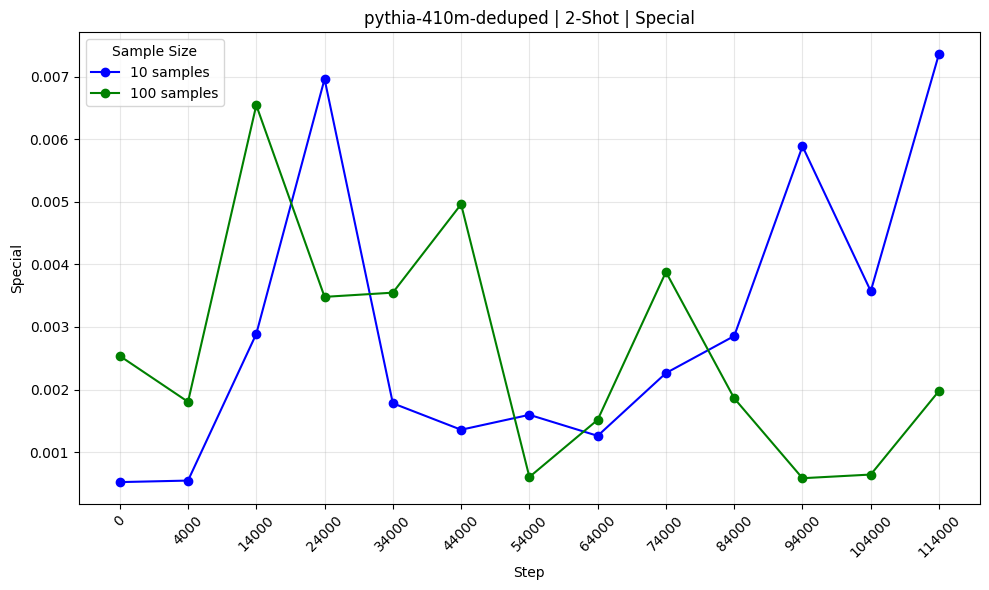

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


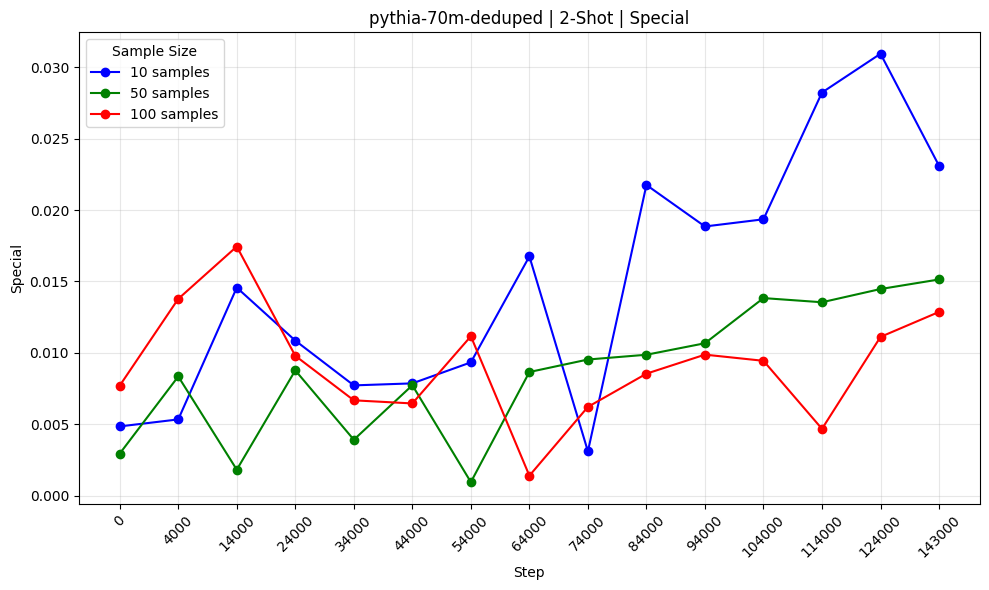

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


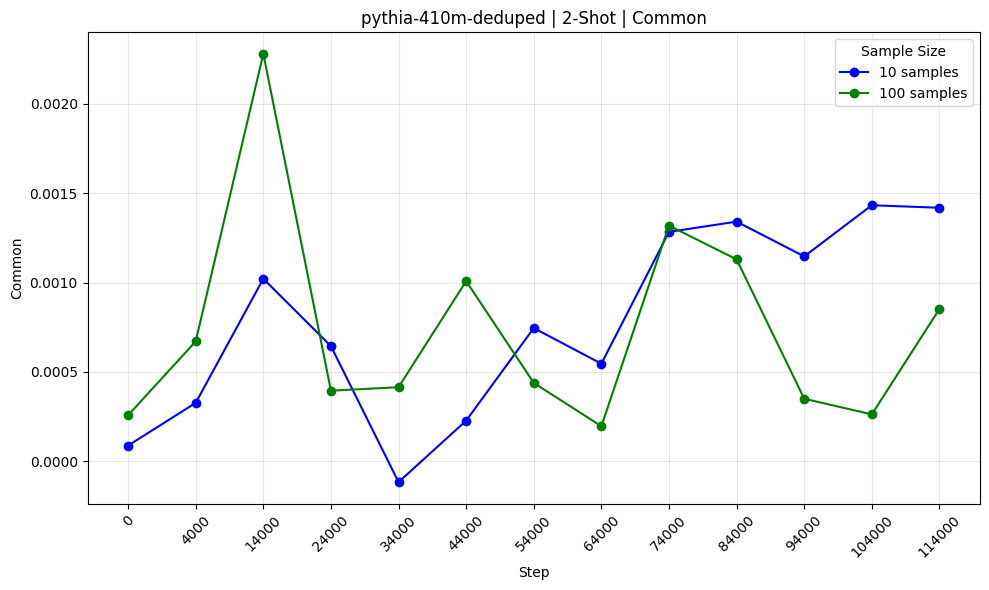

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


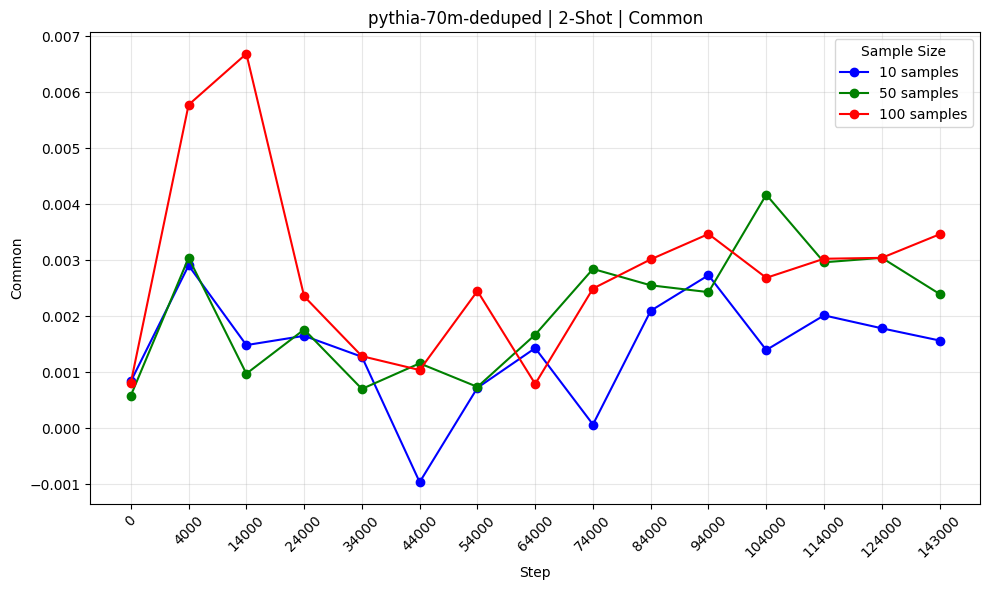

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [10]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/classify'
out_dir= ROOT_dir/'fig/geometry/reflection'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "ref_svm_linear_extreme.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

/Users/jliu/workspace/RAG/results/classify/pythia-70m-deduped/prob/94000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/0/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/50/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/4000/500/100/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/10/2/individual/reflection_stat.json
/Users/jliu/workspace/RAG/results/classify/pythia-410m-deduped/prob/14000/500/50/2/individual

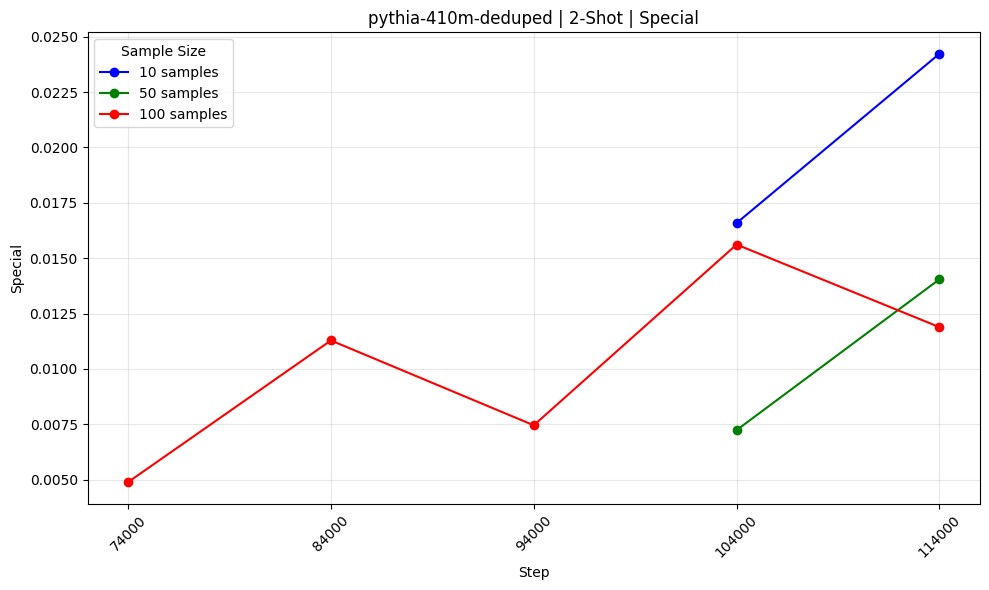

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_special.png


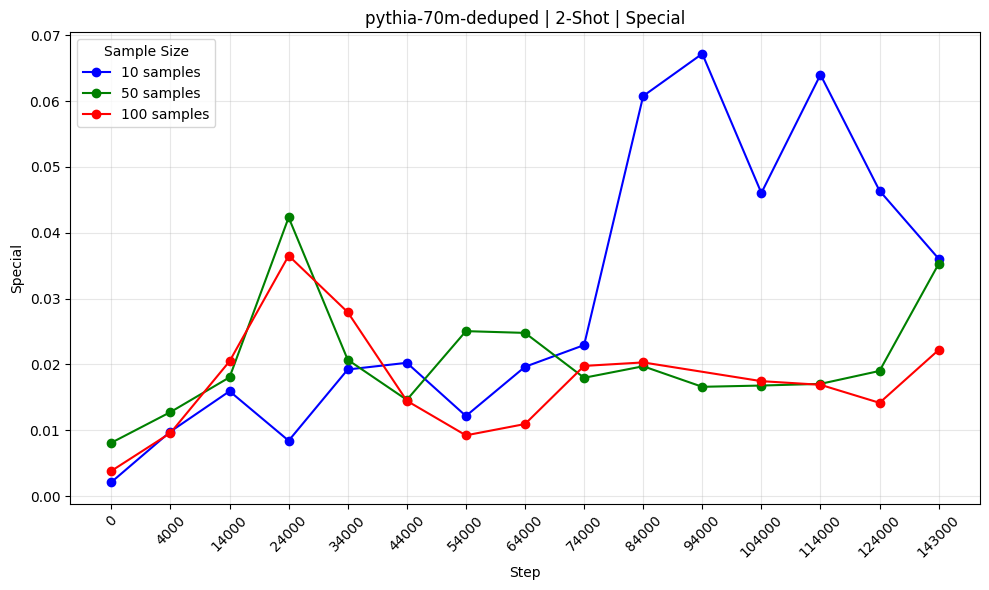

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_special.png


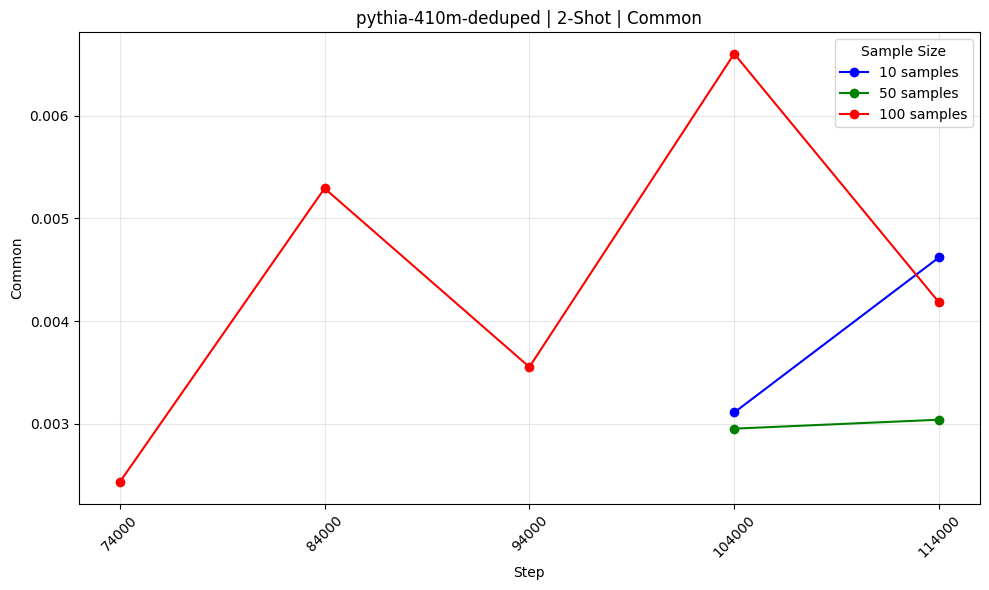

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_410m_deduped_shot2_common.png


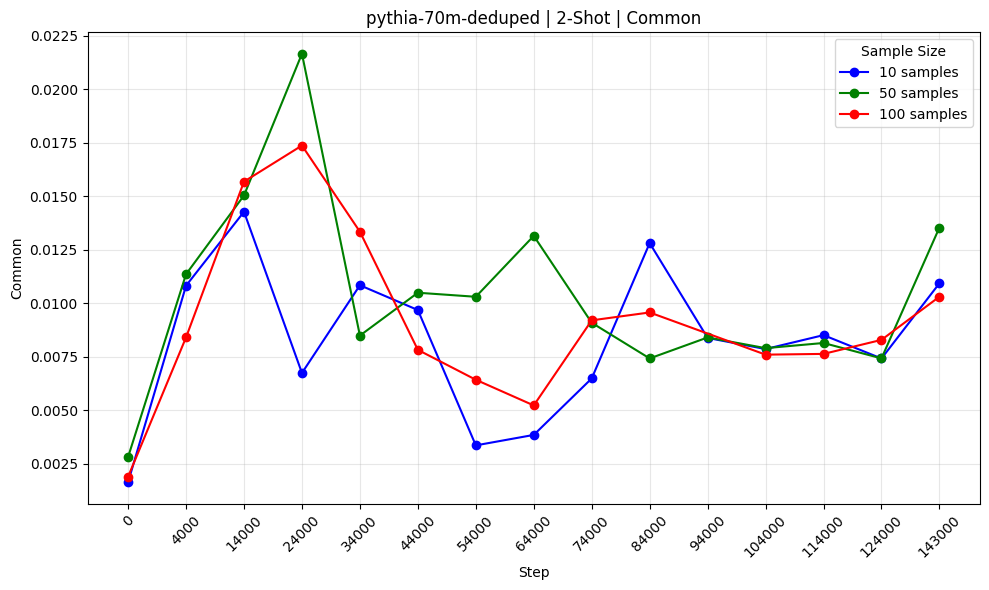

Saved plot to /Users/jliu/workspace/RAG/fig/geometry/reflection/pythia_70m_deduped_shot2_common.png


In [7]:
# loop over differento conditions
DATA_DIR = ROOT_dir/'results/classify'
out_dir= ROOT_dir/'fig/geometry/reflection'
model_name_lst = ["pythia-70m-deduped","pythia-410m-deduped"]
step_lst = [0,4000,14000,24000,34000,44000,54000,64000,74000,84000,94000,104000,114000,124000,143000]
sample_size_lst = [10, 50, 100]
class_num_lst = [2]
group_type_lst = ["individual"]
filename = "reflection_stat.json"
metric_lst = ["special","common"]

run_pipeline (DATA_DIR,metric_lst,out_dir,model_name_lst,step_lst,sample_size_lst,class_num_lst,group_type_lst,filename)

示例文件树结构：/Users/curiostudio/Desktop/llm_final/classify_updated
└── EleutherAI
    ├── pythia-410m-deduped
    │   └── prob
    │       ├── 0
    │       │   └── 500
    │       │       └── 100
    │       │           └── 2
    │       │               └── individual
    │       │                   ├── classification_baseline.json
    │       │                   └── separation_analysis_baseline.json
    │       ├── 104000
    │       │   └── 500
    │       │       ├── 10
    │       │       │   ├── 2
    │       │       │   │   └── individual
    │       │       │   │       ├── classification_baseline.json
    │       │       │   │       ├── classification.json
    │       │       │   │       ├── separation_analysis_baseline.json
    │       │       │   │       └── separation_analysis.json
    │       │       │   └── 3
    │       │       │       └── individual
    │       │       │           ├── classification.json
    │       │       │           └── separation_analysis.json
    │       │       ├── 100

！！！注意：这部分代码是专门处理htsr数据的（见for f in root.rglob('htsr/**/prob/*.json'):—），所以如果是混合上面部分的geometry，也可以直接把母文件路径给它自动跳过不相关数据

In [1]:
##classify-htsr

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# —— 原有映射，保持不变 —— 
SETTING_MAP = {"group_best":"gbest","group_target_size":"gtsize","individual":"indiv"}
MODEL_MAP   = {"pythia-70m-deduped":"70m","pythia-410m-deduped":"410m"}

NEURONS    = [10,50,100]           # 对应文件 500_10.json, 500_50.json, 500_100.json
COLORS     = ['blue','green','red']
CASE_LIST  = ["boost","suppress","random_1"]
CASE_STYLE = {
    "boost":    {"marker":"o","linestyle":"-"},
    "suppress": {"marker":"s","linestyle":"--"},
    "random_1": {"marker":"^","linestyle":":"},
}

# —— 我们的新指标配置 —— 
STAT_CONFIGS = [
    {"name":"ESD Spike Separation","section":"esd_shape","subsection":None,
     "key":"spike_separation","yrange":None},
    {"name":"PL Alpha Hill (↓ heavier tail)","section":"shape_metrics","subsection":None,
     "key":"pl_alpha_hill","yrange":None},
    {"name":"Phase Structured Indicator","section":"phase_transition","subsection":None,
     "key":"phase_metric","yrange":(-2.1,0.5)},
    {"name":"Bulk–Spike Interaction Strength","section":"bulk_spike_interaction","subsection":None,
     "key":"interaction_strength","yrange":None},
]

CMP_CONFIGS = [
    {"name":"Alpha Hill: Boost vs Common","key":"alpha_hill_boost_vs_common"},
    {"name":"Alpha Hill: Suppress vs Common","key":"alpha_hill_suppress_vs_common"},
    {"name":"Alpha Hill: Suppress vs Boost","key":"alpha_hill_suppress_vs_boost"},
    {"name":"Stable Rank: Boost vs Common","key":"stable_rank_boost_vs_common"},
    {"name":"Stable Rank: Suppress vs Common","key":"stable_rank_suppress_vs_common"},
    {"name":"Stable Rank: Suppress vs Boost","key":"stable_rank_suppress_vs_boost"},
    {"name":"Entropy: Boost vs Common","key":"entropy_boost_vs_common"},
    {"name":"Entropy: Suppress vs Common","key":"entropy_suppress_vs_common"},
    {"name":"Entropy: Suppress vs Boost","key":"entropy_suppress_vs_boost"},
]

def slugify(text):
    return re.sub(r'\W+','_', text).strip('_').lower()

def load_all_json(root_dir):
    root = Path(root_dir)
    recs = []
    for f in root.rglob('htsr/**/prob/*.json'):
        parts = list(f.relative_to(root).parts)
        # 去掉末尾的 'prob' 与文件名
        dir_parts = parts[:-2]
        recs.append({
            'dir_parts': dir_parts,
            'filename': f.name,
            'data': json.loads(f.read_text(encoding='utf-8'))
        })
    return recs

def plot_combined(root_dir, out_dir):
    recs = load_all_json(root_dir)

    # 按所在文件夹分组
    groups = {}
    for r in recs:
        key = tuple(r['dir_parts'])
        groups.setdefault(key, []).append(r)

    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    ncols = 2
    nrows = (len(STAT_CONFIGS)+1)//2

    for dir_parts, files in groups.items():
        # 生成图标题
        title_parts = [SETTING_MAP.get(p, MODEL_MAP.get(p, p)) for p in dir_parts]
        suptitle = " | ".join(title_parts)

        # 收集不同 size（10/50/100）对应的数据
        data_dict = {}
        for r in files:
            m = re.match(r'500_(\d+)\.json', r['filename'])
            if m:
                size = int(m.group(1))
                data_dict[size] = r['data']
        if not data_dict:
            continue

        # —— 第一张：四个指标折线图 —— 
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(ncols*6, nrows*4),
                                 squeeze=False)
        axes = axes.flatten()

        for ax, stat in zip(axes, STAT_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                # x 轴：样本 ID，为了可视化我们用排序后的整数 ID
                steps = sorted(int(k) for k in data.keys())
                x = steps

                for case in CASE_LIST:
                    y = []
                    for s in steps:
                        entry = data[str(s)].get(case, {})
                        # 对 phase 字段单独处理
                        if stat["key"] == "phase":
                            phase = entry.get("phase_transition",{}).get("phase")
                            v = 1.0 if phase == "structured" else 0.0
                        else:
                            v = entry.get(stat["section"],{}).get(stat["key"])
                        y.append(np.nan if v is None else v)

                    if all(np.isnan(y)):
                        continue

                    style = CASE_STYLE[case]
                    ax.plot(x, y,
                            color=COLORS[i],
                            marker=style["marker"],
                            linestyle=style["linestyle"],
                            label=f"{case} {nn}")
                    any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel(stat["name"])
            
            if stat["yrange"]:
                ax.set_ylim(*stat["yrange"])
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples / Case", fontsize='small')

        fig.suptitle(suptitle, fontsize=14)
        fig.tight_layout(rect=[0,0,1,0.95])
        fname1 = out / f"{slugify(suptitle)}_metrics.png"
        fig.savefig(fname1, dpi=200)
        plt.close(fig)
        print(f"Saved {fname1}")

        # —— 第二张：三项跨组比较 —— 
        fig2, axes2 = plt.subplots(1, len(CMP_CONFIGS),
                                   figsize=(len(CMP_CONFIGS)*5, 4),
                                   squeeze=False)
        axes2 = axes2.flatten()

        for ax, cmp_stat in zip(axes2, CMP_CONFIGS):
            any_curve = False

            for i, nn in enumerate(NEURONS):
                data = data_dict.get(nn)
                if data is None:
                    continue

                steps = sorted(int(k) for k in data.keys())
                x = steps
                y = []
                for s in steps:
                    comp = data[str(s)].get("comparisons", {})
                    # 根据 key 前缀选择所属子模块
                    if cmp_stat["key"].startswith("alpha_hill"):
                        v = comp.get("shape_metrics",{}).get(cmp_stat["key"])
                    elif cmp_stat["key"].startswith("spike"):
                        v = comp.get("esd_shape",{}).get(cmp_stat["key"])
                    else:
                        v = comp.get("bulk_spike_interaction",{}).get(cmp_stat["key"])
                    y.append(np.nan if v is None else v)

                if all(np.isnan(y)):
                    continue

                # 直接重用 CASE_STYLE 里的 marker/linestyle，也可以定义新的 CMP_STYLE
                style = CASE_STYLE.get(cmp_stat["key"].split("_")[0], {"marker":"o","linestyle":"-"})
                ax.plot(x, y,
                        color=COLORS[i],
                        marker=style["marker"],
                        linestyle=style["linestyle"],
                        label=str(nn))
                any_curve = True

            if not any_curve:
                ax.text(0.5,0.5,"No data", ha='center', va='center', alpha=0.3)

            ax.set_title(cmp_stat["name"])
            ax.set_xlabel("Sample ID")
            ax.set_ylabel("Δ Value")
            ax.grid(alpha=0.3)
            ax.legend(title="# Samples", fontsize='small')

        fig2.suptitle(suptitle + " — Comparisons", fontsize=14)
        fig2.tight_layout(rect=[0,0,1,0.93])
        fname2 = out / f"{slugify(suptitle)}_comparisons.png"
        fig2.savefig(fname2, dpi=200)
        plt.close(fig2)
        print(f"Saved {fname2}")

# —— 示例调用 —— 
if __name__ == '__main__':
    plot_combined(
        root_dir='/Users/jliu/workspace/RAG/results/geometry',
        out_dir='/Users/jliu/workspace/RAG/fig/geometry/htsr'
    )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gbest_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/gtsize_htsr_longtail_50_eleutherai_410m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_70m_comparisons.png


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_metrics.png
Saved /Users/jliu/workspace/RAG/fig/geometry/htsr/indiv_htsr_longtail_50_eleutherai_410m_comparisons.png


## our assumption: 
special: reduced delta loss after reflection 
-> negative for the comparison


common: increased delta loss 
-> positive for the comparison 